# LastFM Recommendation Engine: Collaborative Filter
August 2018

*For comprehensive information and commentary on this project, please see the associated [README file](https://github.com/cipher813/recommender_system)*.

Today we are going to build a basic recommender system based on a Last.fm dataset available at [GroupLens](https://grouplens.org/datasets/hetrec-2011/) on behalf of [Lab41](https://github.com/Lab41/hermes/wiki/Datasets).  The dataset, obtained from LastFM in 2011, contains the play counts of 17,632 artists by 1,892 users. 

Our agenda is as follows:
- Examine the data we are working with by performing initial Exploratory Data Analysis (EDA)
- Build a couple versions of a basic collaborative recommender system:
 - K Nearest Neighbors in sci-kit learn
 - Item Similarity Recommender in TuriCreate
- Assess results

*As a separate analysis, for preliminary EDA work to incorporate content-based filter components to our recommender system, see [Appendix notebooks](https://github.com/cipher813/recommender_system/tree/master/notebooks) for topic modeling of artist tags with K Means Clustering and tSNE, and separately with pyLDAvis. Adding content-based features from metadata, such as artist tags by users, is a key area of further work to build upon this analysis.*

Now lets examine the data we are working with.

### Import packages

Lets go ahead and import every package we will need for our analysis.  Here we will:

- check the kernel to make sure we are using the environment where the appropriate python package dependencies are installed
- import: 
 - pandas and numpy for data manipulation
 - matplotlib and seaborn for charting
 - sci-kit learn for K Means Clustering model
 - turicreate to evaluate various recommender algorithms
 - fuzzywuzzy for fuzzy matching of artist names
- set float number format to 3 decimal places
- set the seed for reproducibility of analysis even from random number initialization

In [1]:
# check kernel environment
import sys
print("Kernel: {}".format(sys.executable))

# Core data analysis packages
import pandas as pd
import numpy as np

# For our EDA charts
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Compressed Sparse Row ("CSR") matrix
from scipy.sparse import csr_matrix 

# use K-Nearest Neighbors to find cosine distance amongst artists
from sklearn.neighbors import NearestNeighbors

# evaluate a variety of recommender system models in the TuriCreate package
import turicreate as tc

# fuzzy string matching to allow for differing spelling of artist names
from fuzzywuzzy import fuzz, process

# set output to three decimals
pd.set_option('display.float_format',lambda x: '%.2f' %x)

# set seed for reproducibility of random number initializations
seed = np.random.RandomState(seed=42)

Kernel: /Users/brianmcmahon/anaconda3/envs/recommender/bin/python


### The Dataset

Six .csv files are provided in this dataset (download from GroupLens [here](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-2k.zip)), consisting of the following:
- **user_artists.dat** (userID, artistID, weight). Plays of artist by user.
- **artists.dat** (id, name, url, pictureURL). ID and name of each artist.  
- **tags.dat** (tagID, tagValue). ID number and content for each tag.
- **user_taggedartists.dat** (userID, artistID, tagID, day, month, year). Tag of artist by user with date.   
- **user_taggedartists-timestamps.dat** (userID, artistID, tagID, timestamp). Tag of artist by user with timestamp.
- **user_friends.dat** (userID, friendID). User/friend relationships.  

Lets take a deeper dive into the data we are working with:

In [2]:
# import our files
plays = pd.read_csv('../data/user_artists.dat',sep='\t')
artists = pd.read_csv('../data/artists.dat',sep='\t',usecols=['id','name'])

# we import to understand what datapoints we have, but do not use these 
# in our collaborative engine
tags = pd.read_csv('../data/tags.dat', sep='\t',encoding='latin-1')
uta = pd.read_csv('../data/user_taggedartists.dat', sep='\t')
utat = pd.read_csv('../data/user_taggedartists-timestamps.dat', sep="\t")
friends = pd.read_csv('../data/user_friends.dat', sep='\t')

In [3]:
# create a function to provide various statistics on our data files
def print_info(df_list, df_name):
    
    # assertion to ensure our two lists are equal in length (ie we didn't make any mistakes)
    assert len(df_list) == len(df_name)

    for i in range(len(df_list)):
        print(df_name[i],'\n')
        print("Shape: {}\n".format(df_list[i].shape))
        print("Info:")
        print(df_list[i].info(),'\n')
        print("Unique:\n{}\n".format(df_list[i].nunique()))     
        
        # This returns True if no duplicates are dropped (ie duplicates do not exist)
        print("No duplicates: {}\n".format(len(df_list[i])==len(df_list[i].drop_duplicates())))

In [4]:
df_list = [plays, artists, tags, uta, utat, friends]
df_name = ['**Plays**',
           '**Artists**',
           '**Tags**',
           '**User Tagged Artists (Date)**',
           '**User Tagged Artists (Timestamp)**',
           '**Friends**']

print_info(df_list,df_name)

**Plays** 

Shape: (92834, 3)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
userID      92834 non-null int64
artistID    92834 non-null int64
weight      92834 non-null int64
dtypes: int64(3)
memory usage: 2.1 MB
None 

Unique:
userID       1892
artistID    17632
weight       5436
dtype: int64

No duplicates: True

**Artists** 

Shape: (17632, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 2 columns):
id      17632 non-null int64
name    17632 non-null object
dtypes: int64(1), object(1)
memory usage: 275.6+ KB
None 

Unique:
id      17632
name    17632
dtype: int64

No duplicates: True

**Tags** 

Shape: (11946, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
tagID       11946 non-null int64
tagValue    11946 non-null object
dtypes: int64(1), object(1)
memory usage: 186.7+ KB
None 

Unique:


In total, we have:
- 1,892 users
- 17,632 artists
- 92,834 artist/user plays
- 11,946 tags
- 186,479 tag assignments

Now we will focus on our artist/user plays data to develop our collaborative recommender.

### Exploratory Data Analysis (EDA): Collaborative Filter

*See the [Appendix notebooks](https://github.com/cipher813/recommender_system/tree/master/notebooks) for preliminary work using topic modeling with K-Means Clustering and tSNE, and separately using pyLDAvis. This is where you will find the EDA **not** directly related to our collaborative system, such as on artist tags by user.*

Key features in our collaborative engine include:
- userID
- artistID, artistName
- userPlays (plays by user of artist)

So we have artist ID and name along with users and plays in a single file, we will merge our two primary data files into one:

In [5]:
ap = pd.merge(artists, 
                plays, 
                how='inner',
                left_on='id',
                right_on='artistID')

ap = ap.rename(columns={"weight":"userArtistPlays"})

ap.head()

,id,name,userID,artistID,userArtistPlays
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152


Here we will derive further valuable information from our dataset, including:

Per user/artist pair:
- *User Artist Plays*. This is our play count data; the amount of plays of one artist by one user.  

Per artist:
- *Total Artist Plays*. Aggregate play count of all users of a single artist.
- *Total Unique Users*. Aggregate users who have listened to an artist at least once.  
- *Average User Plays*. Calculated as Total Artist Plays / Total Unique Users.

Per user:
- *Total User Plays*.  Aggregate plays of all artist by a single user.
- *Total Unique Artists*. The number of artist data available for a single user (the dataset apparently caps this at 50).

In [6]:
artist_rank = (ap.groupby(['name']).agg({'userID':'count','userArtistPlays':'sum'}).
    rename(columns={"userID":'totalUniqueUsers',"userArtistPlays":"totalArtistPlays"}).
              sort_values(['totalArtistPlays'],ascending=False))
artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays']/artist_rank['totalUniqueUsers']
user_rank = (ap.groupby(['userID']).agg({'name':'count','userArtistPlays':'sum'}).
    rename(columns={"name":'totalUniqueArtists',"userArtistPlays":"totalUserPlays"}).
            sort_values(['totalUserPlays'],ascending=False))

In [7]:
# Britney Spears is the most played at 2.4 million plays
artist_rank.head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Britney Spears,522,2393140,4584.56
Depeche Mode,282,1301308,4614.57
Lady Gaga,611,1291387,2113.56
Christina Aguilera,407,1058405,2600.50
Paramore,399,963449,2414.66


Per the total artist plays column we see an average of almost 4,000 plays per artist with a max of 2.4 million (for Britney Spears).  

In [8]:
artist_rank.describe()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
count,17632.00,17632.00,17632.00
mean,5.27,3923.77,423.78
std,20.62,34099.34,785.38
min,1.00,1.00,1.00
25%,1.00,113.00,97.00
50%,1.00,350.00,246.00
75%,3.00,1234.25,496.88
max,611.00,2393140.00,35323.00


Here we have our top users in terms of total play count.  We also see an apparent cap of 50 artists per user, likely a parameter when the original dataset was queried.  

In [9]:
user_rank.head()

,totalUniqueArtists,totalUserPlays
userID,,
757,50,480039
2000,50,468409
1418,50,416349
1642,50,388251
1094,50,379125


For convenience, we will join our artist and user data into a single table.  As such, we will need to be careful when deriving insights from columns.  

In [10]:
ap2 = ap.join(artist_rank,on='name',how='inner')
ap3 = ap2.join(user_rank,on='userID',how='inner').sort_values(['userArtistPlays'],ascending=False)

# confirm no duplicated rows
assert ap3[ap3.duplicated(['userID','name'])].empty

In [11]:
ap3.head()

,id,name,userID,artistID,userArtistPlays,totalUniqueUsers,totalArtistPlays,avgUserPlays,totalUniqueArtists,totalUserPlays
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.57,50,388251
35843,792,Thalía,2071,792,324663,26,350035,13462.88,50,338400
27302,511,U2,1094,511,320725,185,493024,2664.99,50,379125
8152,203,Blur,1905,203,257978,114,318221,2791.41,50,276295
26670,498,Paramore,1664,498,227829,399,963449,2414.66,50,251560


In [12]:
print_info([ap3[['userID','artistID']]],['***Artist Plays***'])

***Artist Plays*** 

Shape: (92834, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 92834 entries, 2800 to 88660
Data columns (total 2 columns):
userID      92834 non-null int64
artistID    92834 non-null int64
dtypes: int64(2)
memory usage: 2.1 MB
None 

Unique:
userID       1892
artistID    17632
dtype: int64

No duplicates: True



Key statistics include:
    
- 17,632 unique artist ID and name
- 1,892 unique user ID
- 92,834 total data points (artist/user pairs)

In [13]:
# 69 million total plays
print("{:,}".format(ap3['userArtistPlays'].sum()))

69,183,975


### Visualizing Data Insights

We will now graphically depict some of our artist and user data to see what insights we can draw from within.  

In [14]:
# our standard bar chart in a function below

def bar_chart_int(x,y,x_label,y_label,title,caption,total_val):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    ax = sns.barplot(x[:20], y[:20], palette="PuRd")
    ax.set_xlabel(x_label,fontweight='bold')
    ax.set_ylabel(y_label,fontweight='bold')
    ax.set_title(title,fontweight='bold')
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x))))

    # our bar label placement
    for p in ax.patches:
        height = p.get_height()
        pct = 100*(height/total_val)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(pct),
                ha="center",verticalalignment='bottom',color='black') 

    # our caption statement
    ax.text(19, max(y[:20])*0.95, caption, style='italic',fontsize=12,horizontalalignment='right')

    plt.xticks(rotation=90)
    plt.show()   

With 2.4 million plays out of a aggregate play count of 69 million in the dataset, Britney Spears received 3.5% of the plays in the dataset.  

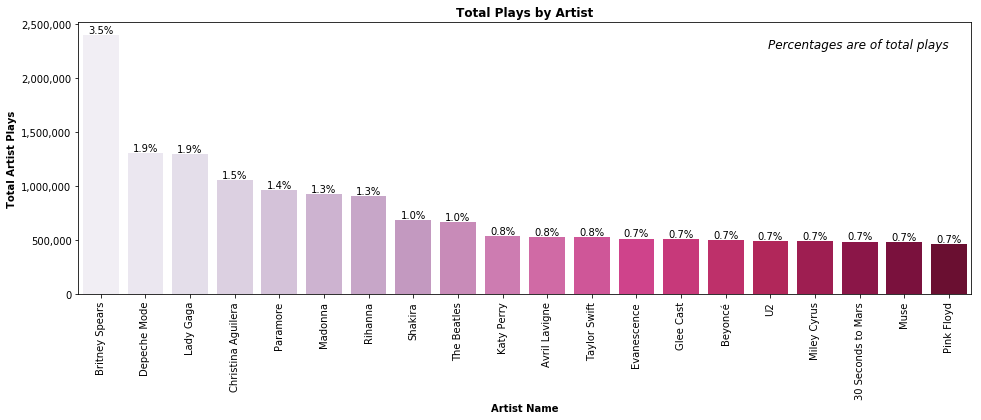

In [15]:
c1 = artist_rank
x = c1.index
y = c1.totalArtistPlays
x_label = 'Artist Name'
y_label = 'Total Artist Plays'
title = 'Total Plays by Artist'
caption = 'Percentages are of total plays'
total_val = c1.totalArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

In [16]:
artist_rank.sort_values(['totalUniqueUsers'],ascending=False).head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Lady Gaga,611,1291387,2113.56
Britney Spears,522,2393140,4584.56
Rihanna,484,905423,1870.71
The Beatles,480,662116,1379.41
Katy Perry,473,532545,1125.89


Of the total 1,892 users in this dataset, 611 of them listened to Lady Gaga at least one time.  That is 32.3% of all users!

In [17]:
len(ap3['userArtistPlays'][ap3['name']=='Lady Gaga'])

611

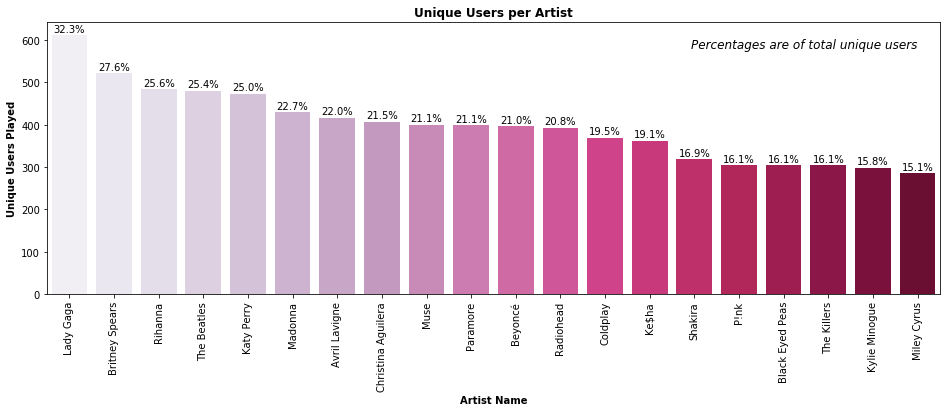

In [18]:
# Lady Gaga has been played by 32.3% of the users in the sample
c2 = artist_rank.sort_values(['totalUniqueUsers'],ascending=False)
x = c2.index
y = c2.totalUniqueUsers
x_label = 'Artist Name'
y_label = 'Unique Users Played'
title = 'Unique Users per Artist'
caption = 'Percentages are of total unique users'
total_val = ap3.userID.nunique()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

As expected, we see general positive correlation between number of artist plays and number of unique users.  We see Britney Spears with the most aggregate plays and Lady Gaga with the most unique listeners.

We compare both metrics (total artist plays vs unique users) on a single chart below.  

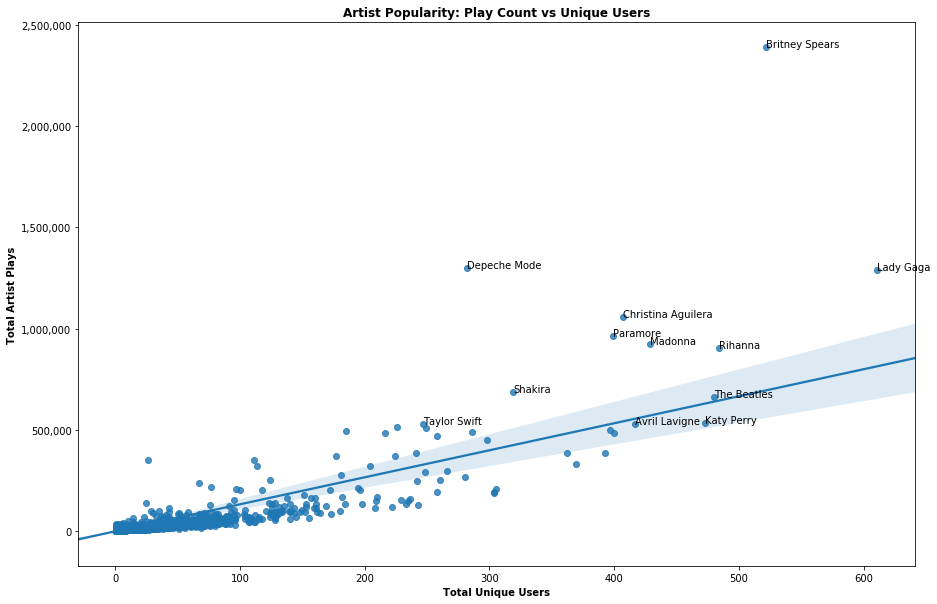

In [19]:
top_artists = artist_rank.sort_values(['totalArtistPlays'],ascending=False).index[:12]

x = artist_rank.totalUniqueUsers
y = artist_rank.totalArtistPlays
labels = artist_rank.index

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x,y)
ax.set_title('Artist Popularity: Play Count vs Unique Users',fontweight='bold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
ax.set_xlabel('Total Unique Users',fontweight='bold')
ax.set_ylabel('Total Artist Plays',fontweight='bold')

for i, t in enumerate(labels):
    if t in top_artists:
        ax.annotate(t,(x[i],y[i]))

Now we look at the activity of each user.  

User #757 accounts for almost 1% of all plays in the dataset with almost 500,000 plays. If we estimate that each play is on average 4 minutes, then 500,000 plays equates to almost 87 24-hour days of continuous play time. Perhaps these are corporate users playing background music?

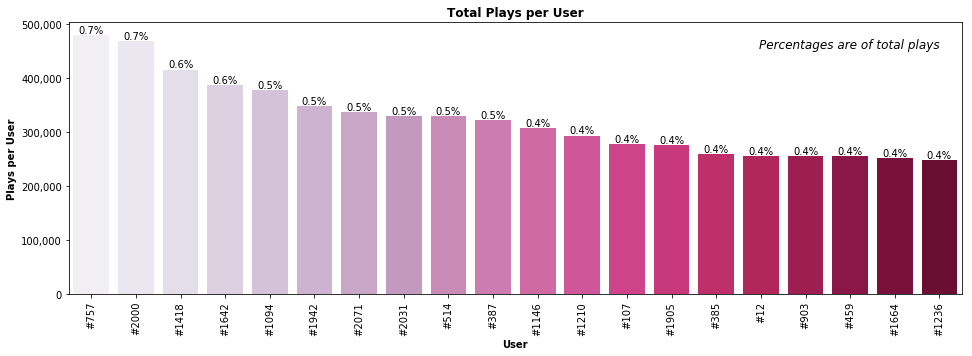

In [20]:
c3 = user_rank.sort_values(['totalUserPlays'],ascending=False)
c3['userID'] = c3.index
c3.userID = c3.userID.apply(lambda x: '#'+str(x))

x = c3.userID
y = c3.totalUserPlays
x_label = 'User'
y_label = 'Plays per User'
title = 'Total Plays per User'
caption = 'Percentages are of total plays'
total_val = ap3.userArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

In [21]:
artist_rank.sort_values(['avgUserPlays'],ascending=False).head()

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Viking Quest,1,35323,35323.00
Tyler Adam,1,30614,30614.00
Rytmus,1,23462,23462.00
Johnny Hallyday,2,32995,16497.50
Dicky Dixon,1,15345,15345.00


Lets look at what we can call user loyalty: the average amount of times a user plays a specific artist.  Again, this is defined as (total artist plays / total unique users).  

Viking Quest has a single unique user which played them 35,000 times.  Thus on average the artist wins out at greatest average plays per user.  

In [22]:
ap3[ap3['name']=='Viking Quest']

,id,name,userID,artistID,userArtistPlays,totalUniqueUsers,totalArtistPlays,avgUserPlays,totalUniqueArtists,totalUserPlays
80046,8388,Viking Quest,596,8388,35323,1,35323,35323.00,50,101469


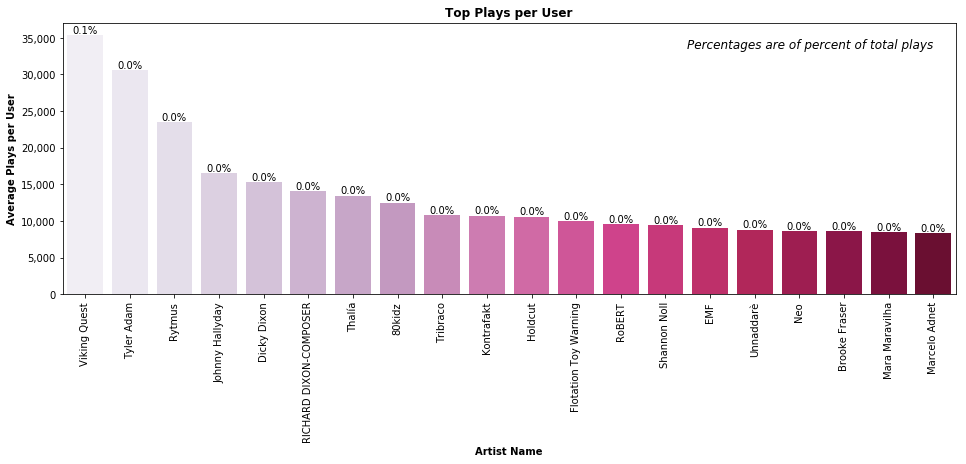

In [23]:
c4 = artist_rank.sort_values(['avgUserPlays'],ascending=False)

x = c4.index
y = c4.avgUserPlays
x_label = 'Artist Name'
y_label = 'Average Plays per User'
title = 'Top Plays per User'
caption = 'Percentages are of percent of total plays'
total_val = ap3.userArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

If we include only popular artists which we will define as over 100 unique users, the most dedicated fans belong to Depeche Mode, followed closely by Britney Spears. 

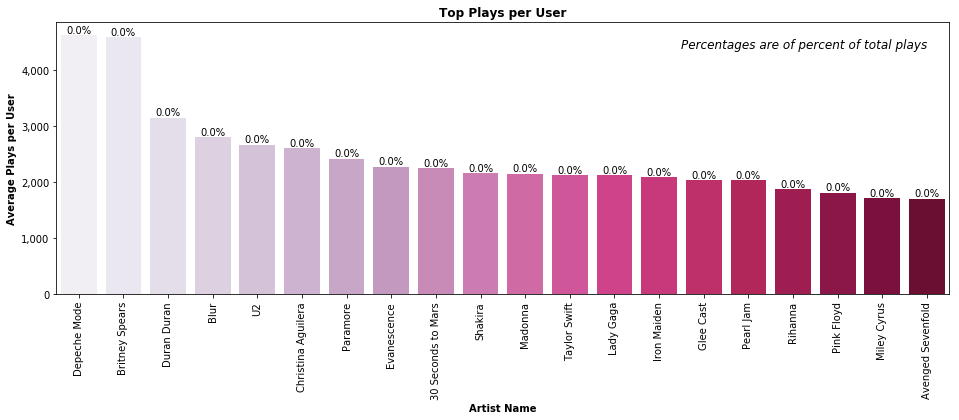

In [24]:
c5 = artist_rank[artist_rank['totalUniqueUsers']>100].sort_values(['avgUserPlays'],ascending=False)

x = c5.index
y = c5.avgUserPlays
x_label = 'Artist Name'
y_label = 'Average Plays per User'
title = 'Top Plays per User'
caption = 'Percentages are of percent of total plays'
total_val = ap3.userArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

# Item Similarity with K-Nearest Neighbors in Scikit Learn

As our first iteration of a basic collaborative recommender, we will build a sparse matrix comparing artist plays (rows) by user (columns). This data will then be passed through a latent mapping algorithm, K-nearest neighbors, to determine cosine similarity amongst the user/artist relationships.  This will help us determine which artists are most similar as in shortest distance apart within this latent mapping.  For instance, as we would see with a relatively small cosine distance between them, when a user plays the Beatles, they also have a high probability of playing the Rolling Stones rather than a more distant artist such as Snoop Dogg.  

### Prepare Sparse Matrix

Here we fit data into a sparse matrix of artist name (row) vs. user (column).  This matrix captures all relationships between artists and users with number of plays in each respective cell.  

In [25]:
# fit data into a sparse matrix of artist name (row) vs user (column)
# in terms of number of plays by artist/user
def data_to_sparse(data,index,columns,values):
    pivot = data.pivot(index=index,columns=columns,values=values).fillna(0)
    sparse = csr_matrix(pivot.values)
    print(sparse.shape)
    return pivot,sparse

# User K Nearest Neighbors to determine cosine distance amongst artists
def fit_knn(sparse):
    knn = NearestNeighbors(metric='cosine')
    knn.fit(sparse)
    print(knn)
    return knn

In [26]:
pivot_ap3,sparse_ap3 = data_to_sparse(ap3,index='name',columns='userID',values='userArtistPlays')

(17632, 1892)


In [27]:
knn = fit_knn(sparse_ap3)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)


In [28]:
pivot_ap3.head()

userID,2,3,4,5,6,7,8,9,10,11,...,2090,2091,2092,2093,2094,2095,2096,2097,2099,2100
name,,,,,,,,,,,,,,,,,,,,,
!!!,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
!DISTAIN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
!deladap,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
#####,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
#2 Orchestra,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Here we lookup artist similarities based on index number within the sparse matrix, with cosine distance in parentheses.

In [29]:
def idx_recommend(data,idx,model,k):
    distances, indices = (model.kneighbors(data.
                                     iloc[idx,:].
                                     values.reshape(1,-1),
                                     n_neighbors=k+1))

    for i in range(0,len(distances.flatten())):
        if i == 0:
            print(('Recommendations for {}:\n'.
                  format(data.index[idx])))
        else:
            print(('{}: {} ({:.3f})'.
                  format(i,
                         data.index[indices.flatten()[i]],
                         distances.flatten()[i])))
    return ''

In [30]:
# we query a random artist
query_index = seed.choice(pivot_ap3.shape[0])
idx_recommend(pivot_ap3,query_index,knn,6)

Recommendations for VINILOVERSUS:

1: Don Davis (0.000)
2: Taking Back Sunday (0.792)
3: Ana Johnsson (0.856)
4: Lacuna Coil (0.864)
5: Breaking Benjamin (0.867)
6: Trapt (0.868)


''

In [31]:
# lookup index number for select artists
query_index = pivot_ap3.index.get_loc('Britney Spears')
idx_recommend(pivot_ap3,query_index,knn,6)

Recommendations for Britney Spears:

1: Lindsay Lohan (0.504)
2: RuPaul (0.567)
3: Sarah Michelle Gellar (0.568)
4: mclusky (0.568)
5: Анастасия Приходько (0.568)
6: †‡† (0.570)


''

In [32]:
query_index = pivot_ap3.index.get_loc('Oasis')
idx_recommend(pivot_ap3,query_index,knn,6)

Recommendations for Oasis:

1: Fuel (0.349)
2: The Perishers (0.355)
3: Vertical Horizon (0.386)
4: The Wreckers (0.406)
5: The Vines (0.471)
6: Calogero (0.534)


''

### Query by Artist (with Fuzzy Matching)

Here we implement direct artist lookup using fuzzy matching for partial name matches.  

In [33]:
# this will help us to locate partial matches of our query
def fuzzy_match(query_subject,data):
    ratio_tuples = []
    
    # each artist name is the subject in the data index
    # each artist in the data is compared against our query subject to determine percentage match
    # NOTE there may be ways to optimize this process by not looping through all artists
    for subject in data.index:
        ratio = fuzz.ratio(subject.lower(),query_subject.lower())
        current_query_idx = data.index.tolist().index(subject)
        ratio_tuples.append((subject, ratio,current_query_idx))
        
    # our findings are then sorted based on match rating, and top two are kept
    ratio_tuples = sorted(ratio_tuples, key=lambda tup: tup[1],reverse=True)[:2]
    
    print('Top matches: {}\n'.format([(x[0],x[1]) for x in ratio_tuples]))  
    
    match = ratio_tuples[0][0]
    
    return match, ratio_tuples

def artist_recommend(query_artist, data, model,k):
    
    # determine artist matches using fuzzy matching
    
    match, ratio_tuples = fuzzy_match(query_artist,data)
    
    # look up artist by query index
    idx_recommend(data, ratio_tuples[0][2],model,k)   
    return ''

Subjectively applying music domain knowledge, the recommendations below are largely in the ballpark, but we will work on further refining these.  Below we will look into reducing noise by including only popular artists and active users, and also either bucketizing or binarizing our play counts.

In [34]:
artist_recommend('britney spears',pivot_ap3,knn,10)

Top matches: [('Britney Spears', 100), ('Britney Spears⊼', 97)]

Recommendations for Britney Spears:

1: Lindsay Lohan (0.504)
2: RuPaul (0.567)
3: Sarah Michelle Gellar (0.568)
4: mclusky (0.568)
5: Анастасия Приходько (0.568)
6: †‡† (0.570)
7: Nadia Oh (0.570)
8: Rachel Stevens (0.571)
9: L'Âme Immortelle (0.596)
10: Hilary Duff (0.622)


''

In [35]:
artist_recommend('nirvana',pivot_ap3,knn,10)

Top matches: [('Nirvana', 100), ('Nina', 73)]

Recommendations for Nirvana:

1: Nullset (0.130)
2: SoundGarden | www.CdsCompletos.net (0.130)
3: Humberto Gessinger Trio (0.130)
4: Green River (0.130)
5: Infectious Grooves (0.130)
6: 4 Non Blondes (0.135)
7: Puddle of Mudd (0.144)
8: Meat Puppets (0.152)
9: Institute (0.302)
10: Living Colour (0.309)


''

In [36]:
artist_recommend('red hot chillis',pivot_ap3,knn,10)

Top matches: [('Red Hot Chili Peppers', 78), ('The Chills', 64)]

Recommendations for Red Hot Chili Peppers:

1: The Offspring (0.568)
2: Kreator (0.630)
3: Bloodhound Gang (0.660)
4: 5'nizza (0.689)
5: Steppenwolf (0.691)
6: Beatallica (0.692)
7: Ногу Свело! (0.692)
8: Mercyful Fate (0.692)
9: John Frusciante (0.692)
10: Ленинград (0.692)


''

### Feature Scaling: Apply Threshold

Here we apply thresholds to keep only popular artists and active users.  This reduces noise in our data in an aim to improve our recommendations.

We will filter as follows.

Users:
- _Minimum Plays per User_. Minimum aggregate play count per user.  
- _Minimum Unique Artist Plays_. A user needs to play at least this many different artists to be counted.

Artists:
- _Minimum Artist Plays_. Minimum times an artist must be played.  
- _Minimum Listeners_. Minimum unique users per artist.  

In [37]:
minPlaysPerUser = 1000 # minimum aggregate play count per user
minUniqueArtistPlays = 10 # minimum different artists that need values per user to be counted
minArtistPlays = 10000 # minimum times an artist must be played
minListeners = 10 # minimum unique listeners of artist to be played

def apply_threshold(data,
                    minPlaysPerUser,
                    minUniqueArtistPlays,
                    minArtistPlays,
                    minListeners):
    
    filtered = (data[(data['totalUserPlays']>=minPlaysPerUser) & 
               (data['totalUniqueArtists']>=minUniqueArtistPlays) & 
               (data['totalArtistPlays']>=minArtistPlays) & 
               (data['totalUniqueUsers']>=minListeners)])

    # confirm our min thresholds have been applied
    print('MINIMUM VALUES')
    print('totalUserPlays from {} to {}'.format(min(data.totalUserPlays),min(filtered.totalUserPlays)))
    print('totalUniqueArtists from {} to {}'.format(min(data.totalUniqueArtists),min(filtered.totalUniqueArtists)))
    print('totalArtistPlays from {} to {}'.format(min(data.totalArtistPlays),min(filtered.totalArtistPlays)))
    print('totalUniqueUsers from {} to {}'.format(min(data.totalUniqueUsers),min(filtered.totalUniqueUsers)))

    print('\nFILTER IMPACT')
    print("FILTERED Users: {} Artists: {}".format(len(filtered['userID'].unique()),
                                                           len(filtered['name'].unique())))
    print("ORIGINAL Users: {} Artists: {}".format(len(data['userID'].unique()),
                                                           len(data['name'].unique())))
    print("FILTERED % ORIGINAL Users: {:.1f}% Artists: {:.1f}%".format(100*(len(filtered['userID'].unique())/len(data['userID'].unique())),
                                                           100*(len(filtered['name'].unique())/len(data['name'].unique()))))
    return filtered

ap4 = apply_threshold(ap3,minPlaysPerUser,minUniqueArtistPlays,minArtistPlays,minListeners)

ap4[['totalUserPlays','totalUniqueArtists','totalArtistPlays','totalUniqueUsers']].describe()

MINIMUM VALUES
totalUserPlays from 3 to 1001
totalUniqueArtists from 1 to 10
totalArtistPlays from 1 to 10007
totalUniqueUsers from 1 to 10

FILTER IMPACT
FILTERED Users: 1790 Artists: 871
ORIGINAL Users: 1892 Artists: 17632
FILTERED % ORIGINAL Users: 94.6% Artists: 4.9%


,totalUserPlays,totalUniqueArtists,totalArtistPlays,totalUniqueUsers
count,52298.00,52298.00,52298.00,52298.00
mean,41467.40,49.87,192603.24,144.96
std,50438.77,1.70,336597.43,135.10
min,1001.00,10.00,10007.00,10.00
25%,13094.00,50.00,27175.00,45.00
50%,25511.00,50.00,64596.00,89.00
75%,48311.00,50.00,188634.00,208.00
max,480039.00,50.00,2393140.00,611.00


In [38]:
pivot_ap4,sparse_ap4 = data_to_sparse(ap4,index='name',columns='userID',values='userArtistPlays')
knn = fit_knn(sparse_ap4)

(871, 1790)
NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)


After applying the threshold, our results are looking better, but we still may be able to improve further.  We can also explore standardizing our artist plays into buckets or binarized, discussed below.

In [39]:
artist_recommend('red hot chillis',pivot_ap4,knn,10)

Top matches: [('Red Hot Chili Peppers', 78), ('Hot Chip', 61)]

Recommendations for Red Hot Chili Peppers:

1: The Offspring (0.568)
2: Kreator (0.630)
3: John Frusciante (0.692)
4: Ennio Morricone (0.694)
5: In Extremo (0.696)
6: Riverside (0.697)
7: Katie Melua (0.701)
8: Ben Folds (0.702)
9: Bush (0.718)
10: Mylène Farmer (0.721)


''

### Feature Scaling: Convert plays to buckets

We will now convert our raw play counts into five buckets.  A rating of five will represent a true fan while a one has played the artist but appears to prefer others more.  A zero still means the user has never played the artist.   

In [40]:
ap4['userArtistPlays'].describe()

count    52298.00
mean       992.30
std       4885.03
min          1.00
25%        139.00
50%        323.00
75%        771.00
max     352698.00
Name: userArtistPlays, dtype: float64

In [41]:
# convert our play counts into ratings buckets
# a rating of 2 requires more than one play
# a rating of at least 1 is given for >=1 play (else 0)

b = ap4['userArtistPlays']
buckets = np.linspace(b.quantile(.005),b.quantile(.995),5)
print("Bucket thresholds: {}".format([int(b) for b in buckets]))
print("For instance, if value is {}, then the rank would be {}.".
      format(int(buckets[0]+1),len(buckets[:1])+1))

def bucketize(x):
    cur_bucket = 0
    for i in range(0,5):
        cur_bucket += 1
        if x <= buckets[i]:
            break
    return cur_bucket

Bucket thresholds: [6, 4621, 9237, 13853, 18469]
For instance, if value is 7, then the rank would be 2.


In [42]:
ap5 = ap4
ap5['rank'] = ap5['userArtistPlays'].apply(bucketize)

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
ap5.groupby(['rank'])['userArtistPlays'].describe().T

rank,1,2,3,4,5
count,304.00,50493.00,872.00,254.00,375.00
mean,3.49,585.26,6230.25,11294.57,37443.69
std,1.73,737.34,1246.27,1272.97,42039.23
min,1.00,7.00,4627.00,9275.00,13860.00
25%,2.00,137.00,5186.00,10205.50,17133.50
50%,4.00,311.00,5889.50,11114.50,23830.00
75%,5.00,710.00,7138.75,12318.00,37931.50
max,6.00,4621.00,9199.00,13831.00,352698.00


In [44]:
pivot_ap5,sparse_ap5 = data_to_sparse(ap5,index='name',columns='userID',values='rank')
knn = fit_knn(sparse_ap5)

(871, 1790)
NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)


Although cosine distance has increased marginally, the buckets seem to have improved our recommendations substantially.  

In [45]:
artist_recommend('red hot chillis',pivot_ap5,knn,10)

Top matches: [('Red Hot Chili Peppers', 78), ('Hot Chip', 61)]

Recommendations for Red Hot Chili Peppers:

1: Nirvana (0.650)
2: Oasis (0.672)
3: Foo Fighters (0.685)
4: The Beatles (0.692)
5: Muse (0.706)
6: U2 (0.720)
7: Radiohead (0.721)
8: Aerosmith (0.722)
9: System of a Down (0.723)
10: Green Day (0.724)


''

### Feature Scaling: Convert plays to binary

Lets see if we can improve our model results by replacing our buckets with a binary rating system.

Our binary classification will consist of played (1) or not played (0).

In [46]:
ap6 = ap4
ap6['everPlayed'] = ap6['userArtistPlays'].apply(np.sign) # np.sign converts all positive values to one.

/Users/brianmcmahon/anaconda3/envs/recommender/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [47]:
pivot_ap6,sparse_ap6 = data_to_sparse(ap6,index='name',columns='userID',values='everPlayed')
knn = fit_knn(sparse_ap6)

(871, 1790)
NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)


In [48]:
artist_recommend('red hot chillis',pivot_ap6,knn,10)

Top matches: [('Red Hot Chili Peppers', 78), ('Hot Chip', 61)]

Recommendations for Red Hot Chili Peppers:

1: Nirvana (0.649)
2: Oasis (0.677)
3: The Beatles (0.687)
4: Foo Fighters (0.688)
5: Muse (0.713)
6: Radiohead (0.717)
7: U2 (0.717)
8: Aerosmith (0.723)
9: Green Day (0.723)
10: System of a Down (0.726)


''

In [49]:
# lets try out some different artists
artist_list = [
               'Britney Spears',
               'Snoop Dogg',
               'Eminem',
               'Beatles',
               'D Bowie',
               'Tiesto',
               'Basshunter',
               'Akon',
               'Ace of Base',
               'Garth Brooks',
              ]

for artist in artist_list:
    print(artist_recommend(artist,pivot_ap6,knn,10))
    print('\n')

Top matches: [('Britney Spears', 100), ('Jordin Sparks', 67)]

Recommendations for Britney Spears:

1: Rihanna (0.168)
2: Christina Aguilera (0.213)
3: Lady Gaga (0.224)
4: Katy Perry (0.229)
5: Beyoncé (0.250)
6: Ke$ha (0.299)
7: Shakira (0.337)
8: Miley Cyrus (0.338)
9: Madonna (0.338)
10: Avril Lavigne (0.359)



Top matches: [('Snoop Dogg', 100), ('No Doubt', 56)]

Recommendations for Snoop Dogg:

1: Ice Cube (0.496)
2: 2Pac (0.522)
3: DMX (0.605)
4: D12 (0.655)
5: Nas (0.658)
6: Jay-Z (0.661)
7: Busta Rhymes (0.671)
8: Mobb Deep (0.697)
9: 50 Cent (0.701)
10: Cypress Hill (0.743)



Top matches: [('Eminem', 100), ('The Maine', 67)]

Recommendations for Eminem:

1: Ke$ha (0.630)
2: Rihanna (0.649)
3: Katy Perry (0.651)
4: B.o.B (0.667)
5: Britney Spears (0.669)
6: Lady Gaga (0.669)
7: Black Eyed Peas (0.674)
8: P!nk (0.684)
9: Miley Cyrus (0.686)
10: Christina Aguilera (0.695)



Top matches: [('The Beatles', 78), ('Beastie Boys', 63)]

Recommendations for The Beatles:

1: Radiohea

From the original data, we filtered out inactive users and unpopular artists, and implemented K Nearest Neighbors on (1) the original play count by user, (2) a bucketed rank per user based on play count, and (3) binary values as to whether the user had ever played the artist.  

As both the bucketed and binary methods produced reasonable and comparable results, then by [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor) we would prefer the binary method.  

We will now explore the capabilities of TuriCreate's recommendation engine platform.  

# Implementation with TuriCreate

TuriCreate, formerly GraphLab, is a "graph-based, high performance, distributed computation framework" per [Wikipedia](https://en.wikipedia.org/wiki/GraphLab).  It was developed to simplify the development of custom machine learning models.  Turi was acquired by Apple Inc. for $200 million on August 5, 2016.  

Here we will explore TuriCreate's recommendation engine capabilities by implementing our recommender system on the platform.  

In [50]:
# convert our pandas dataframe into a turicreate SFrame
sf = tc.SFrame(ap6)

In [51]:
sf.head()

id,name,userID,artistID,userArtistPlays,totalUniqueUsers,totalArtistPlays
72,Depeche Mode,1642,72,352698,282,1301308
792,Thalía,2071,792,324663,26,350035
511,U2,1094,511,320725,185,493024
203,Blur,1905,203,257978,114,318221
498,Paramore,1664,498,227829,399,963449
378,Evanescence,1146,378,203165,226,513476
292,Christina Aguilera,514,292,176133,407,1058405
701,Shakira,1983,701,172496,319,688529
701,Shakira,757,701,169596,319,688529
679,Glee Cast,1086,679,165902,249,506453


The show() method is comparable to describe() in pandas, where the output are a statistical summary by column.  

Here we once again see that the vast majority of users have listened to 50 artists; as such we would presume this was an artifical cutoff point when the data was originally queried.  

The total user plays, total artist plays and total unique users per artist are all skewed on the left near zero with a long right tail, as we would expect.

We can also confirm here that our minimum values from our threshold filtering above remain in effect.  

In [63]:
# commented out as it will not render properly on GitHub
# sf[['totalUniqueArtists','totalUserPlays','totalUniqueUsers','totalArtistPlays']].show()

We will now explore a variety of models offered within TuriCreate.  We split our data into train and test sets for purposes of evaluating precision/recall in all models and RMSE where we have a target value (ie played/not played).

In [53]:
# split data into train and test sets
train, test = tc.recommender.util.random_split_by_user(sf,
                                                       user_id='userID',
                                                       item_id='name')

In [54]:
# we will test seven different model variations enabled with turicreate
def train_models(train_data, test_data,user_id,item_id,target):

    # popularity, no target
    m1 = tc.popularity_recommender.create(train_data,
                                          user_id=user_id,
                                          item_id=item_id,
                                          verbose=False
                                          )
    # similarity, no target
    m2 = tc.item_similarity_recommender.create(train_data,
                                               user_id=user_id,
                                               item_id=item_id,
                                               verbose=False,
                                               similarity_type='jaccard'
                                               )
    # ranking factorize, no target
    m3 = tc.ranking_factorization_recommender.create(train_data,
                                                     user_id=user_id,
                                                     item_id=item_id,
                                                     verbose=False
                                                     )
    # popularity with target
    m4 = tc.popularity_recommender.create(train_data,
                                          user_id=user_id,
                                          item_id=item_id,
                                          target=target,
                                          verbose=False
                                          )

    # ranking factorize with target
    m5 = tc.ranking_factorization_recommender.create(train_data,
                                                     user_id=user_id,
                                                     item_id=item_id,
                                                     target=target,
                                                     verbose=False
                                                     )
    # factorization with target
    m6 = tc.factorization_recommender.create(train_data,
                                             user_id=user_id,
                                             item_id=item_id,
                                             target=target,
                                             verbose=False
                                                       )
    # default with target
    m7 = tc.recommender.create(train_data,
                               user_id=user_id,
                               item_id=item_id,
                               target=target,
                               verbose=False      
                              )
    
    model_list = m1, m2, m3, m4, m5, m6, m7
    
    name_list = ['1. Popularity (Implicit, No Target)',
                 '2. Item Similarity (Implicit, No Target)',
                 '3. Ranking Factorization (Implicit, No Target)',
                 '4. Popularity (Explicit, With Target)',
                 '5. Ranking Factorization (Explicit, With Target)',
                 '6. Factorization (With Target)',
                 '7. Default (Explicit, With Target)']

    results = tc.recommender.util.compare_models(test_data,
                                                models=[m for m in model_list],
                                                model_names=[n for n in name_list],
                                                metric='auto')

    return model_list, name_list, results

### Model Evaluation: Precision and Recall

Here we train our model and run the model against the test set to determine recommendation quality.  Metrics to review include RMSE for models with target values and precision/recall for models without targets.  

Per these metrics below, it appears that our item similarity recommender (model 2) achieves the greatest precision and recall of all models tested, at 9% and 14% respectively. 

However, on an absolute scale, it would be presumed that there remains ample opportunity to further improve these results.  We would ideally like to see each of these approach 100%.  The precision metric tells us the recommendations the user actually liked out of all recommendations made, calculated as True Positive / (True Positive + False Positive).  The recall metric tells us ratio of items a user likes that were actually recommended, calculated as True Positive / (True Positive + False Negative).  

Say we have 100 items, of which a user likes 10.  If we recommend all items, the recommender would achive 100% recall, but our precision would be 10%.  If we recommend 20 items, including the user's 10, we would achieve 100% recall and 50% precision.  If we recommend 5 items, all of which the user liked, we would achieve 100% precision but only 50% recall.  Only if we recommend exactly those 10 liked items will we achieve 100% in both precision and recall.   

In [55]:
# training our seven models with a binarized target (played or not played)
model_list, name_list, results = train_models(train, 
                                              test,
                                              user_id='userID',
                                              item_id='name',
                                              target='everPlayed')

Recsys training: model = popularity

Recsys training: model = item_similarity

Recsys training: model = ranking_factorization_recommender

Recsys training: model = popularity

Recsys training: model = ranking_factorization_recommender

Recsys training: model = factorization_recommender

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 46421 observations with 1789 users and 871 items.

Data prepared in: 0.165409s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46421 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 4.54545           | Not Viable                               |

| 1       | 1.13636           | Not Viable                               |

| 2       | 0.284091          | Not Viable                               |

| 3       | 0.0710227         | Not Viable                               |

| 4       | 0.0177557         | No Decrease (0.270444 >= 0.250141)       |

| 5       | 0.00443892        | 0.239026                                 |

| 6       | 0.00221946        | 0.235408                                 |

| 7       | 0.00110973        | 0.243374                                 |

| 8       | 0.000554865       | 0.244633                                 |

| 9       | 0.000277433       | 0.247441                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.00221946        | 0.235408                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 109us        | 0.250143          | 0.00095408            |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 391.608ms    | 0.287831          | 0.174895              | 0.00221946  |

| 2       | 745.305ms    | 0.23699           | 0.0762133             | 0.00221946  |

| 3       | 1.16s        | 0.231863          | 0.0640026             | 0.00221946  |

| 4       | 1.51s        | 0.233096          | 0.0721148             | 0.00221946  |

| 5       | 1.88s        | 0.233126          | 0.0727286             | 0.00221946  |

| 6       | 2.44s        | 0.234533          | 0.0840747             | 0.00221946  |

| 10      | 4.07s        | 0.22937           | 0.0740935             | 0.00221946  |

| 11      | 4.46s        | 0.232523          | 0.0873559             | 0.00221946  |

| 15      | 5.91s        | 0.229225          | 0.0835057             | 0.00221946  |

| 20      | 7.92s        | 0.232529          | 0.102007              | 0.00221946  |

| 25      | 9.70s        | 0.230582          | 0.0998448             | 0.00221946  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.251909

Final training RMSE: 0.154788

PROGRESS: Evaluate model 1. Popularity (Implicit, No Target)

Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.10629514963880295 | 0.01486851068894413  |
|   2    | 0.10010319917440659 | 0.029249059047820648 |
|   3    | 0.10939112487100112 | 0.049611287691783024 |
|   4    |  0.0959752321981425 | 0.05661423772878884  |
|   5    | 0.08648090815273472 | 0.06435184182862198  |
|   6    | 0.07980736154110768 | 0.07117611490676497  |
|   7    | 0.07445083296476486 | 0.07780520992595305  |
|   8    | 0.07391640866873067 | 0.08712204834495861  |
|   9    | 0.07338607957802995 | 0.09629263924929563  |
|   10   | 0.07203302373581011 | 0.10548728017768255  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model 2. Item Similarity (Implicit, No Target)



Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.09287925696594425 | 0.014405216959396526 |
|   2    | 0.10526315789473695 | 0.031809453016883336 |
|   3    | 0.10629514963880306 | 0.04721921238949111  |
|   4    | 0.10681114551083587 | 0.06517707152382063  |
|   5    |  0.1060887512899896 |  0.0803740176805191  |
|   6    | 0.10457516339869269 | 0.09587180105755949  |
|   7    |  0.1018723278785198 | 0.11002291768545643  |
|   8    | 0.09945820433436525 | 0.12393044405428308  |
|   9    | 0.09597523219814236 | 0.13400756450292048  |
|   10   | 0.09360165118679052 | 0.14536822253540524  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model 3. Ranking Factorization (Implicit, No Target)



Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.13622291021671842 |  0.0201038584165519  |
|   2    | 0.09907120743034056 | 0.029408797829850446 |
|   3    | 0.08875128998968018 | 0.03993299155837853  |
|   4    | 0.08900928792569662 | 0.055167401684429525 |
|   5    | 0.08235294117647068 | 0.06263666960261384  |
|   6    | 0.07963536291709676 | 0.07319948140381574  |
|   7    |  0.0757776794928498 | 0.07985691925320403  |
|   8    | 0.07430340557275546 | 0.08800813909173046  |
|   9    | 0.07338607957803003 | 0.09749729974188165  |
|   10   | 0.07234262125902992 | 0.10697758840173696  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model 4. Popularity (Explicit, With Target)

Precision and recall summary statistics by cutoff
+--------+------------------

Lets take recommendations for some specific users and compare recommendations by model.  Below we will query each of the TuriCreate models for a list of users.  This list consists of 5 top users and 5 random users.  The output below, for each user, will first be their top artists by plays, and then recommendations generated by each of the seven TuriCreate models.  

In [56]:
# determine a user list for which to pull custom recommendations
top_users = user_rank.index[:5]
rand_users = seed.choice(sf['userID'],5)
user_list = list(top_users) + list(rand_users)
print("User list consists of:\nTop Users: {}\nRandom Users: {}".format(list(top_users),list(rand_users)))

User list consists of:
Top Users: [757, 2000, 1418, 1642, 1094]
Random Users: [527, 1170, 1798, 214, 2084]


In [57]:
def played_vs_rec(users,df,model_list,name_list,user_id,item_id,plays,target):
    assert len(model_list)==len(name_list)
    print("User List: {}\n".format(users))
    df = df[[user_id,item_id,plays,target]]
    for user in users:
        print('USER {}\n'.format(str(user)))
        print('***TOP PLAYS***')
        print(df[df[user_id]==user].sort(plays,ascending=False))
        print('\n')
        print('***RECOMMENDATIONS***')
        for i in range(len(model_list)):
            print('***{}***'.format(name_list[i]))
            results = model_list[i].recommend(users=[user],k=4)
            print(results)
        print('\n')

For the results below, it is difficult to tell the quality of recommendations by model for our users who prefer the most popular music, such as Britney Spears or Lady Gaga.  But if we look at users that have different tastes, such as (for example) User #1642 who likes Depeche Mode, Model 2 seems to provide the most reasonable results (ie Duran Duran, New Order, Recoil and Erasure).  User # 1094 enjoys U2 and R.E.M., and model 2 recommends Oasis and The Killers, which also appear in-line.  

In [58]:
# although score improves, results seem to worsen when target is used in the model
played_vs_rec(user_list,
              sf,
              model_list,
              name_list,
              user_id='userID',
              item_id='name',
              plays='userArtistPlays',
              target='everPlayed')

User List: [757, 2000, 1418, 1642, 1094, 527, 1170, 1798, 214, 2084]

USER 757

***TOP PLAYS***
+--------+------------------+-----------------+------------+
| userID |       name       | userArtistPlays | everPlayed |
+--------+------------------+-----------------+------------+
|  757   |     Shakira      |      169596     |     1      |
|  757   |     Beyoncé      |      60877      |     1      |
|  757   |     Rihanna      |      31800      |     1      |
|  757   |  Britney Spears  |      30230      |     1      |
|  757   |      Eminem      |      26933      |     1      |
|  757   | Black Eyed Peas  |      26767      |     1      |
|  757   | Enrique Iglesias |      26723      |     1      |
|  757   | Michael Jackson  |      26148      |     1      |
|  757   |      Ke$ha       |      23277      |     1      |
|  757   |   Miley Cyrus    |      20003      |     1      |
+--------+------------------+-----------------+------------+
[41 rows x 4 columns]
Note: Only the head of the S

+--------+-----------------------+-----------------+------------+
| userID |          name         | userArtistPlays | everPlayed |
+--------+-----------------------+-----------------+------------+
|  1418  |       Lady Gaga       |      75414      |     1      |
|  1418  | The Devil Wears Prada |      39826      |     1      |
|  1418  |        Paramore       |      31834      |     1      |
|  1418  |       Hadouken!       |      30566      |     1      |
|  1418  |     Good Charlotte    |      28859      |     1      |
|  1418  |          Muse         |      27211      |     1      |
|  1418  |     Avril Lavigne     |      25575      |     1      |
|  1418  |     Enter Shikari     |      24663      |     1      |
|  1418  |      Linkin Park      |      18012      |     1      |
|  1418  |   Asking Alexandria   |      15147      |     1      |
+--------+-----------------------+-----------------+------------+
[28 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can 

+--------+-------------+--------------------+------+
| userID |     name    |       score        | rank |
+--------+-------------+--------------------+------+
|  1094  | Miley Cyrus | 1.0149176232516766 |  1   |
|  1094  |   Beyoncé   | 1.001153890043497  |  2   |
|  1094  |   Shakira   | 0.9769414402544498 |  3   |
|  1094  | Evanescence | 0.9727772064507008 |  4   |
+--------+-------------+--------------------+------+
[4 rows x 4 columns]

***6. Factorization (With Target)***
+--------+-----------------+--------------------+------+
| userID |       name      |       score        | rank |
+--------+-----------------+--------------------+------+
|  1094  |      Thalía     | 1.000303021240807  |  1   |
|  1094  | Sarah Brightman | 1.0001869374794303 |  2   |
|  1094  |    Katy Perry   | 1.0001674975717805 |  3   |
|  1094  |      SHINee     | 1.0001633482692824 |  4   |
+--------+-----------------+--------------------+------+
[4 rows x 4 columns]

***7. Default (Explicit, With Target)**

+--------+----------------+-------+------+
| userID |      name      | score | rank |
+--------+----------------+-------+------+
|  1798  |   Lady Gaga    | 542.0 |  1   |
|  1798  | Britney Spears | 464.0 |  2   |
|  1798  |    Rihanna     | 418.0 |  3   |
|  1798  |   Katy Perry   | 410.0 |  4   |
+--------+----------------+-------+------+
[4 rows x 4 columns]

***2. Item Similarity (Implicit, No Target)***
+--------+--------------+---------------------+------+
| userID |     name     |        score        | rank |
+--------+--------------+---------------------+------+
|  1798  | Depeche Mode | 0.07025288105010986 |  1   |
|  1798  |    Oasis     | 0.06496736526489258 |  2   |
|  1798  | The Killers  | 0.06210854768753052 |  3   |
|  1798  | The Strokes  | 0.05538184881210327 |  4   |
+--------+--------------+---------------------+------+
[4 rows x 4 columns]

***3. Ranking Factorization (Implicit, No Target)***
+--------+---------------+--------------------+------+
| userID |      n

Applying our music domain knowledge, it appears that model 2, item similarity recommender, is providing each user the best results based on their listening history.  Lets use this model for our recommendations.  

We re-run the user list top plays and model 2 recommendations below.  

In [59]:
# Using the item similarity recommender, lets compare top plays with recommendations
# for our user list
played_vs_rec(user_list,
              sf,
              [model_list[1]],
              [name_list[1]],
              user_id='userID',
              item_id='name',
              plays='userArtistPlays',
              target='everPlayed')

User List: [757, 2000, 1418, 1642, 1094, 527, 1170, 1798, 214, 2084]

USER 757

***TOP PLAYS***
+--------+------------------+-----------------+------------+
| userID |       name       | userArtistPlays | everPlayed |
+--------+------------------+-----------------+------------+
|  757   |     Shakira      |      169596     |     1      |
|  757   |     Beyoncé      |      60877      |     1      |
|  757   |     Rihanna      |      31800      |     1      |
|  757   |  Britney Spears  |      30230      |     1      |
|  757   |      Eminem      |      26933      |     1      |
|  757   | Black Eyed Peas  |      26767      |     1      |
|  757   | Enrique Iglesias |      26723      |     1      |
|  757   | Michael Jackson  |      26148      |     1      |
|  757   |      Ke$ha       |      23277      |     1      |
|  757   |   Miley Cyrus    |      20003      |     1      |
+--------+------------------+-----------------+------------+
[41 rows x 4 columns]
Note: Only the head of the S

+--------+--------------------------+-----------------+------------+
| userID |           name           | userArtistPlays | everPlayed |
+--------+--------------------------+-----------------+------------+
|  1170  |         Paramore         |       3899      |     1      |
|  1170  |      Arctic Monkeys      |       1270      |     1      |
|  1170  |     Yeah Yeah Yeahs      |       870       |     1      |
|  1170  |        The Kooks         |       828       |     1      |
|  1170  |        Cat Power         |       751       |     1      |
|  1170  | The All-American Rejects |       580       |     1      |
|  1170  |        Lily Allen        |       570       |     1      |
|  1170  |       The Beatles        |       452       |     1      |
|  1170  |       Maxïmo Park        |       426       |     1      |
|  1170  |    Cansei de Ser Sexy    |       403       |     1      |
+--------+--------------------------+-----------------+------------+
[36 rows x 4 columns]
Note: Only t

### Finding Similar Items

Similar to what we did with our K Nearest Neighbors model in sci-kit learn, we will also use the TuriCreate item similarity recommender model (model 2, our top performant) to find artist similarity.  

In [60]:
artist_list

['Britney Spears',
 'Snoop Dogg',
 'Eminem',
 'Beatles',
 'D Bowie',
 'Tiesto',
 'Basshunter',
 'Akon',
 'Ace of Base',
 'Garth Brooks']

In [61]:
def find_similar(artist_list,model_list,data):
    for artist in artist_list:
        print(artist.upper())
        fuzz = process.extract(artist,data,limit=2) # applying fuzzy matching
        print(model_list[1].get_similar_items([fuzz[0][0]],k=5))     
    return ''

In [62]:
find_similar(artist_list,model_list,sf['name'])

BRITNEY SPEARS
+----------------+--------------------+--------------------+------+
|      name      |      similar       |       score        | rank |
+----------------+--------------------+--------------------+------+
| Britney Spears |      Rihanna       | 0.594936728477478  |  1   |
| Britney Spears | Christina Aguilera | 0.5689980983734131 |  2   |
| Britney Spears |     Katy Perry     | 0.5387324094772339 |  3   |
| Britney Spears |     Lady Gaga      | 0.538226306438446  |  4   |
| Britney Spears |      Beyoncé       | 0.5074626803398132 |  5   |
+----------------+--------------------+--------------------+------+
[5 rows x 4 columns]

SNOOP DOGG
+------------+--------------+---------------------+------+
|    name    |   similar    |        score        | rank |
+------------+--------------+---------------------+------+
| Snoop Dogg |     2Pac     |         0.25        |  1   |
| Snoop Dogg |     DMX      | 0.22727274894714355 |  2   |
| Snoop Dogg |   Ice Cube   | 0.2173913121223

''

_Please see project README for general information and analysis of this project._